# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [2]:
import importlib
from datetime import timedelta
import pandas as pd

import matplotlib.dates as mdates
import numpy as np
from matplotlib import pyplot as plt

import util
import main

importlib.reload(util)
importlib.reload(main)

<module 'main' from '/Users/yaskovdev/dev/git_home/sandbox/service-instance-estimation/main.py'>

In [3]:
# Example format of the TSV file:
# "StartTime","EndTime"
# "2025-05-16 19:50:03.2040000","2025-05-16 21:02:22.8440000"
# "2025-05-16 19:52:30.7260000","2025-05-16 21:00:30.1480000"
# "2025-05-16 19:53:15.0750000","2025-05-16 21:13:08.4190000"
# ...

df = pd.read_csv(r'~/dev/tmpABB9.tmp.txt', sep=',')
df['StartTime'] = pd.to_datetime(df['StartTime'])
df['EndTime'] = pd.to_datetime(df['EndTime'])

sessions = list(zip(df['StartTime'], df['EndTime']))
sessions = [session for session in sessions if session[0] < session[1]]

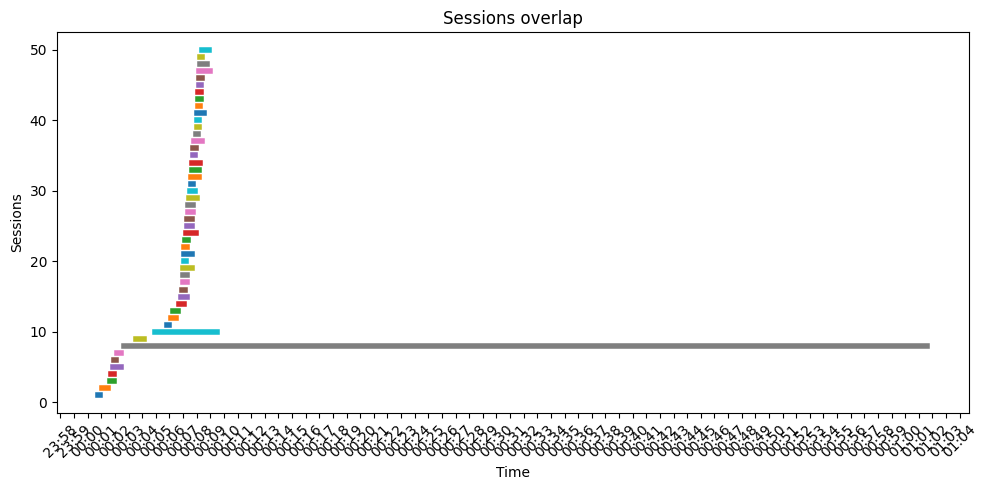

In [4]:
fig, ax = plt.subplots(figsize=(10, 5))

for i, (start, end) in enumerate(sorted(sessions[:50], key=lambda x: x[0])):
    ax.plot([start, end], [i + 1, i + 1], label=f"Session {i + 1}", linewidth=4)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
plt.xticks(rotation=45)

ax.set_xlabel("Time")
ax.set_ylabel("Sessions")
ax.set_title("Sessions overlap")

plt.tight_layout()
plt.show()

In [5]:
def format_time(seconds):
    if seconds < 60:
        return f"{seconds:.1f} s"

    minutes, seconds = divmod(seconds, 60)
    if minutes < 60:
        return f"{int(minutes)}m {seconds:.1f}s"

    hours, minutes = divmod(minutes, 60)
    return f"{int(hours)}h {int(minutes)}m {seconds:.1f}s"

In [6]:
total_composers = 220
composition_speed = 2
delay_threshold_s = timedelta(minutes=2).total_seconds()
delays_s = main.calculate_delays_s(sessions, total_composers, composition_speed)

delays_s_np = np.array(delays_s)

In [7]:
statistics = {
    "max_delay": delays_s_np.max(),
    "avg_delay": delays_s_np.mean(),
    "95th_percentile": np.percentile(delays_s_np, 95),
    "percent_under_threshold": (delays_s_np <= delay_threshold_s).mean() * 100,
    "delays": delays_s,
}

n_delays = 10
print(f"Top {n_delays} delays in s: {sorted(delays_s, reverse=True)[:n_delays]}")

meets_sla = statistics['95th_percentile'] <= delay_threshold_s
status = "✅ OK" if meets_sla else "❌ FAIL"

print(f"{total_composers} instances: "
      f"Max delay = {format_time(statistics['max_delay'])}, "
      f"Avg delay = {format_time(statistics['avg_delay'])}, "
      f"95th = {format_time(statistics['95th_percentile'])}, "
      f"% under threshold = {statistics['percent_under_threshold']}, "
      f"→ {status}")

Top 10 delays in s: [839.523, 838.0635, 837.1555, 836.6285, 835.5865, 835.389, 834.699, 834.3405, 833.6105, 833.298]
220 instances: Max delay = 13m 59.5s, Avg delay = 16.9 s, 95th = 1m 29.3s, % under threshold = 95.6853775236317, → ✅ OK
